# Получение тренировочных и тестовых данных

Исходные данные представляют из себя логи взаимодействия пользователя с товаром.

Имеющиеся признаки:
* session_id - ID сессии пользователя
* item_id - ID товара
* event_name - тип события, которое произвел пользователь с товаром. Всего может быть 4 события:
    1. view_item_list - просмотр товара
    2. select_item - клик по товару
    3. add_to_wishlist - добавление товара к списку "избранное"
    4. add_to_cart - добавление в корзину
* keyword - строка запроса пользователя

Для формирования таргета (релевантности товара запросу) событиям дается искусственный вес. Например, добавление в корзину считается самым важным показателем релевантности товара запросу, поэтому имеет большой вес. Напротив, просмотр не говорит о релевантности ничего, т.к. такое событие логируется всегда, даже в том случае, когда поисковая выдача абсолютно нерелевантна запросу.

In [1]:
import sys
sys.path.append('src/')

In [2]:
from src.tokenizer import Tokenizer

In [3]:
import pandas as pd
import re
from itertools import groupby
import numpy as np
from sklearn.preprocessing import minmax_scale
from tqdm.auto import tqdm

tqdm.pandas()

## 1. Data loading and processing

In [4]:
tokenizer = Tokenizer()

In [5]:
def normalize_keyword(keyword):
    return ' '.join(sorted(tokenizer.tokenize(keyword)))

Нормализация запроса необходима для снижения количества уникальных запросов. Поисковой системе все равно в каком порядке идут токены запроса.

In [6]:
normalize_keyword('игрушечные солдатики аврора')

'аврор игрушечн солдатик'

Данные загружены ранее и в открытый доступ не выложены.

In [7]:
df = pd.read_parquet('data/user_data.parquet')
df

,session_id,item_id,event_name,keyword
0,7582292472044581353,100029543366,view_item_list,мужская одежда gonso
1,7582292472044581353,100029694703,view_item_list,мужская одежда gonso
2,7582292472044581353,600001966244,view_item_list,мужская одежда gonso
3,7582292472044581353,600009509295,view_item_list,мужская одежда gonso
4,7582292472044581353,100027431389,view_item_list,мужская одежда gonso
...,...,...,...,...
181617314,9056125625193781695,600003422371,view_item_list,111.01924.1
181617315,-753829019918929680,100024263287,select_item,kt-2208
181617316,-2141953844129662156,600011516505,select_item,gz88037-c
181617317,2210722118130960975,100028427005,select_item,карат карамельный


Маппинг весов событий:

In [8]:
event_mapping = {'add_to_cart': 100, 'add_to_wishlist': 10, 'select_item': 1, 'view_item_list': 0}

In [9]:
df['event_relevance'] = df.event_name.map(event_mapping)

Токенизация и фильтрация:

In [10]:
tmp = df[['keyword']].drop_duplicates()
tmp = tmp[tmp.keyword.apply(lambda x: False if re.match('^\d+$', x) else True)].reset_index(drop=True)
tmp['norm_keyword'] = tmp.keyword.progress_apply(normalize_keyword)

  0%|          | 0/1331342 [00:00<?, ?it/s]

In [11]:
df = df.merge(tmp, on=['keyword']).dropna()
df.head()

,session_id,item_id,event_name,keyword,event_relevance,norm_keyword
0,7582292472044581353,100029543366,view_item_list,мужская одежда gonso,0,gonso мужск одежд
1,7582292472044581353,100029694703,view_item_list,мужская одежда gonso,0,gonso мужск одежд
2,7582292472044581353,600001966244,view_item_list,мужская одежда gonso,0,gonso мужск одежд
3,7582292472044581353,600009509295,view_item_list,мужская одежда gonso,0,gonso мужск одежд
4,7582292472044581353,100027431389,view_item_list,мужская одежда gonso,0,gonso мужск одежд


In [12]:
df.shape

(181615813, 6)

## 2. Target calculating
### 2.1. Session processing
Для начала суммируется вес событий в рамках сессии для пар запрос - товар.

In [13]:
%%time
df = df.sort_values(['session_id', 'norm_keyword', 'item_id']).reset_index(drop=True)

CPU times: user 2min 29s, sys: 29.4 s, total: 2min 59s
Wall time: 2min 58s


In [14]:
%%time
relevance_data = []
for _, session in tqdm(groupby(df.itertuples(), key=lambda x: x[1]), total=df.session_id.nunique()):
    session = list(session)
    # фильтрация сессий только с просмотрами
    if sum([x.event_relevance for x in session]) == 0:
        continue
    # суммирование весов событий в рамках сессий для пар запрос-товар
    # перебор в цикле быстрее группировки
    prev_id = session[0].item_id
    prev_keyword = session[0].norm_keyword
    tmp = [[prev_keyword, prev_id, 0]]
    for row in session:
        if row.norm_keyword == prev_keyword:
            if row.item_id == prev_id:
                tmp[-1][-1] += row.event_relevance
            else:
                tmp.append([row.norm_keyword, row.item_id, row.event_relevance])
                prev_id = row.item_id
        else:
            tmp.append([row.norm_keyword, row.item_id, row.event_relevance])
            prev_id = row.item_id
            prev_keyword = row.norm_keyword
    relevance_data += tmp

  0%|          | 0/2763732 [00:00<?, ?it/s]

CPU times: user 4min 4s, sys: 17.5 s, total: 4min 22s
Wall time: 4min 19s


In [15]:
len(relevance_data)

125063396

In [16]:
relevance_data = pd.DataFrame(relevance_data, columns=['keyword', 'item_id', 'relevance'])
relevance_data

,keyword,item_id,relevance
0,10 grandorf для кг корм собак,100001276483,0
1,10 grandorf для кг корм собак,100001276610,0
2,10 grandorf для кг корм собак,100023050564,0
3,10 grandorf для кг корм собак,100027339188,0
4,10 grandorf для кг корм собак,100028116091,0
...,...,...,...
125063391,для кошек план про стерилизова утк,100028667613,0
125063392,для кошек план про стерилизова утк,100039726094,0
125063393,для кошек план про стерилизова утк,100042110881,0
125063394,для кошек план про стерилизова утк,100046676947,0


In [17]:
relevance_data.to_parquet('data/relevance_data.parquet', index=False)

### 2.2. Pairs aggregating
Для каждой пары запрос-товар таргет - усредненное значение весов. На данном этапе на среднее значение сильно влиияют просмотры (события с нулевым весом).

In [4]:
relevance_data = pd.read_parquet('data/relevance_data.parquet')

In [5]:
%%time
relevance_data = relevance_data.groupby(['keyword', 'item_id']).relevance.mean()

CPU times: user 42.4 s, sys: 8.23 s, total: 50.6 s
Wall time: 50.6 s


In [6]:
relevance_data = pd.DataFrame(relevance_data.reset_index(), columns=['keyword', 'item_id', 'relevance'])
relevance_data

,keyword,item_id,relevance
0,,100001322409,0.0
1,,100001323818,0.0
2,,100001325451,0.0
3,,100013201860,0.0
4,,100016182586,0.0
...,...,...,...
42806217,яюлок,100045468513,0.0
42806218,яюлок,100045557506,0.0
42806219,яюлок,600001822330,0.0
42806220,яягод,100029578096,0.0


Теперь же просмотры можно удалить из данных.

In [7]:
relevance_data = relevance_data[(relevance_data.keyword != '') & (relevance_data.relevance != 0)]
relevance_data.shape

(2038592, 3)

Так же фильтруются запросы со слишком низким количеством релевантных товаров.

In [9]:
tmp = relevance_data.groupby('keyword').item_id.nunique()

In [13]:
relevance_data = relevance_data[relevance_data.keyword.isin(tmp[tmp > 5].index)]
relevance_data.agg({"keyword": "nunique", "item_id": "nunique"})

keyword     48582
item_id    630615
dtype: int64

Чтобы растянуть масштаб таргета применяется логарифмирование.

<AxesSubplot: >

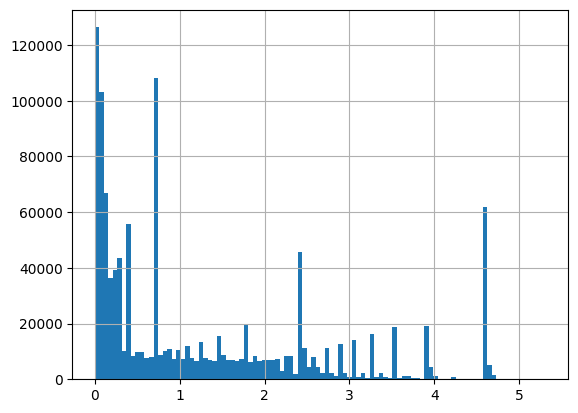

In [21]:
relevance_data.relevance = relevance_data.relevance.apply(lambda x: np.log(1 + x))
relevance_data.relevance.hist(bins=100)

## 3. Train-test split

In [28]:
keywords = relevance_data.keyword.unique()
np.random.shuffle(keywords)

train_size = int(0.8 * len(keywords))
train_keywords = keywords[:train_size]
test_keywords = keywords[train_size:]

In [29]:
len(train_keywords)

38865

In [31]:
train = relevance_data[relevance_data.keyword.isin(train_keywords)]
test = relevance_data[relevance_data.keyword.isin(test_keywords)]

In [34]:
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)

In [35]:
relevance_data.to_csv('data/relevance_data.csv', index=False)

## 4. Simple metrics making [DEPRECATED]

Расчет простых метрик товара на основе исходных данных. Можно обучать агента на воздействие на коэффициенты этих метрик.

In [30]:
relevance_data = pd.read_csv('data/relevance_data.csv')
relevance_data

,keyword,item_id,relevance
0,0 000 1 1400 2 673 edition k karcher universal...,100001322597,0.405465
1,0 000 1 1400 2 673 edition k karcher universal...,100001325223,0.693147
2,0 000 1 1400 2 673 edition k karcher universal...,100013196777,0.405465
3,0 000 1 1400 2 673 edition k karcher universal...,100024448131,3.931826
4,0 000 1 1400 2 673 edition k karcher universal...,100026038206,4.624973
...,...,...,...
1154062,ящик,600002996248,0.055570
1154063,ящик,600003699719,0.693147
1154064,ящик,600009268170,3.931826
1154065,ящик,600011403382,2.397895


In [31]:
%%time
feature_data = df[df.item_id.isin(relevance_data.item_id.unique())].groupby('item_id').agg(
    cnt=("session_id", "count"),
    uniq_sessions=("session_id", "nunique"),
    uniq_keywords=("keyword", "nunique"),
    uniq_events=("event_name", "nunique"),
    view_cnt=("event_name", lambda x: sum(x == "view_item_list")),
    select_cnt=("event_name", lambda x: sum(x == "select_item")),
    add_to_wish_cnt=("event_name", lambda x: sum(x == "add_to_wishlist")),
    add_to_cart_cnt=("event_name", lambda x: sum(x == "add_to_cart"))
)

CPU times: user 6min, sys: 17.8 s, total: 6min 18s
Wall time: 6min 18s


In [8]:
df.agg({"session_id": "nunique", "keyword": "nunique"})

session_id    2763824
keyword       1331538
dtype: int64

In [9]:
uniq_sessions = 2763824
uniq_keywords = 1331538

In [32]:
feature_data = feature_data.reset_index()
feature_data

,item_id,cnt,uniq_sessions,uniq_keywords,uniq_events,view_cnt,select_cnt,add_to_wish_cnt,add_to_cart_cnt
0,100000000117,399,383,73,4,393,4,1,1
1,100000000125,665,647,114,2,662,3,0,0
2,100000000244,17,16,15,2,16,1,0,0
3,100000000350,21,21,12,2,20,1,0,0
4,100000000419,32,28,13,4,28,2,1,1
...,...,...,...,...,...,...,...,...,...
630610,600012398187,2,1,1,2,1,0,1,0
630611,600012398384,4,3,1,2,3,1,0,0
630612,600012467513,2,1,1,2,1,1,0,0
630613,600012489079,2,1,1,2,1,1,0,0


In [33]:
feature_data.to_csv('data/feature_data.csv', index=False)